First 5 Rows of the Data:
   User ID  Age Gender  Sleep Quality Bedtime Wake-up Time  Daily Steps  \
0        1   25      f            8.0   23:00         6:30         8000   
1        2   34      m            7.0    0:30         7:00         5000   
2        3   29      f            9.0   22:45         6:45         9000   
3        4   41      m            5.0    1:00         6:30         4000   
4        5   22      f            8.0   23:30         7:00        10000   

   Calories Burned Physical Activity Level Dietary Habits Sleep Disorders  \
0           2500.0                  medium        healthy              no   
1           2200.0                     low      unhealthy             yes   
2           2700.0                    high        healthy              no   
3           2100.0                     low      unhealthy             yes   
4           2800.0                    high         medium              no   

  Medication Usage  
0               no  
1              yes

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


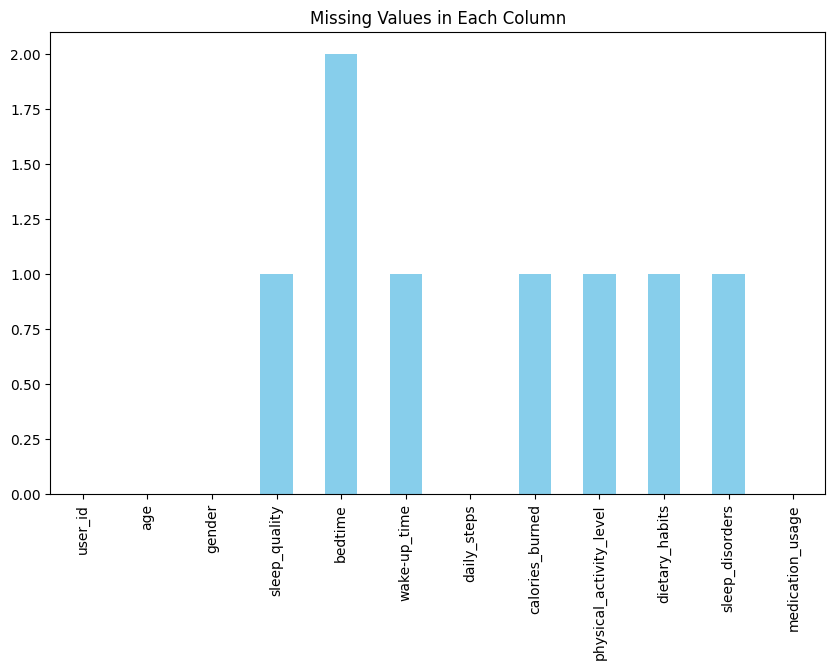

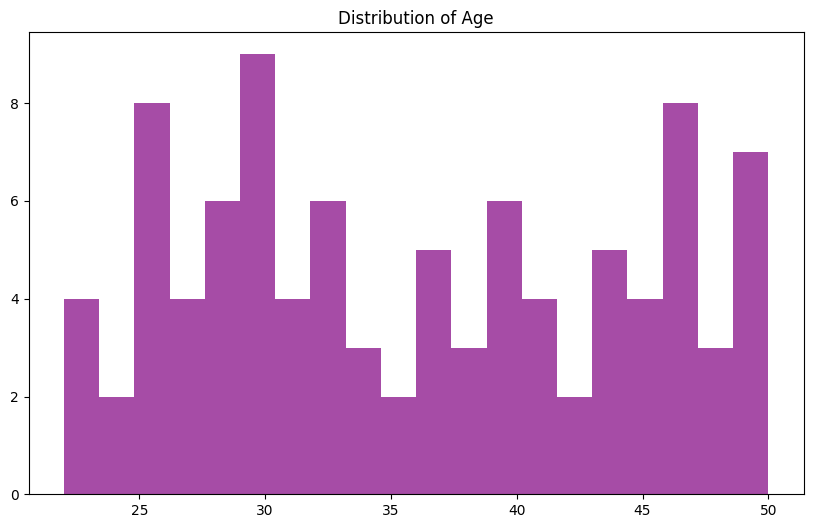


Data summary saved to data_summary.json

Loaded JSON Summary:
{'Missing Values': {'user_id': 0, 'age': 0, 'gender': 0, 'sleep_quality': 1, 'bedtime': 2, 'wake-up_time': 1, 'daily_steps': 0, 'calories_burned': 1, 'physical_activity_level': 1, 'dietary_habits': 1, 'sleep_disorders': 1, 'medication_usage': 0}, 'Summary Statistics': {'user_id': {'count': 23.0, 'mean': 84.65217391304348, 'std': 7.912066134318772, 'min': 73.0, '25%': 78.5, '50%': 84.0, '75%': 89.5, 'max': 100.0}, 'age': {'count': 23.0, 'mean': 36.69565217391305, 'std': 9.32462420694746, 'min': 23.0, '25%': 28.5, '50%': 36.0, '75%': 45.5, 'max': 50.0}, 'gender': {'count': 23.0, 'mean': 0.5217391304347826, 'std': 0.5107539184552491, 'min': 0.0, '25%': 0.0, '50%': 1.0, '75%': 1.0, 'max': 1.0}, 'sleep_quality': {'count': 23.0, 'mean': 6.869565217391305, 'std': 1.866068980165304, 'min': 4.0, '25%': 5.5, '50%': 7.0, '75%': 8.5, 'max': 9.0}, 'daily_steps': {'count': 23.0, 'mean': 6586.95652173913, 'std': 2512.0264090653777, 'min':

In [ ]:


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import requests
from concurrent.futures import ThreadPoolExecutor
from bs4 import BeautifulSoup
from sklearn.preprocessing import StandardScaler, LabelEncoder
from multiprocessing import Process, Queue

file_path = 'Health_Sleep_Statistics.csv'
data = pd.read_csv("/content/Health_Sleep_Statistics.csv")

# Display Basic Information
print("First 5 Rows of the Data:")
print(data.head())
print("\nDescriptive Statistics:")
print(data.describe())
print("\nColumn Names:")
print(data.columns)
print("\nData Information:")
data.info()

data.columns = data.columns.str.strip().str.lower().str.replace(' ', '_')  # Normalize column names
missing_values = data.isnull().sum()

text_cols = ['gender', 'physical_activity_level', 'dietary_habits']
for col in text_cols:
    if col in data.columns:
        data[col] = data[col].str.lower().str.strip()

data['bedtime'] = pd.to_datetime(data['bedtime'], format='%H:%M', errors='coerce').dt.time
data['wake-up_time'] = pd.to_datetime(data['wake-up_time'], format='%H:%M', errors='coerce').dt.time

data.dropna(inplace=True)

label_encoder = LabelEncoder()
data['gender'] = label_encoder.fit_transform(data['gender'])

def process_data_chunk(chunk):
    """Process a chunk of data and return descriptive statistics."""
    return chunk.describe()

chunks = np.array_split(data, 4)
with ThreadPoolExecutor() as executor:
    results = list(executor.map(process_data_chunk, chunks))

# Combine results
summary_statistics = pd.concat(results)
print("\nSummary Statistics Using Multithreading:")
print(summary_statistics)


def save_and_show_plot(fig, title):
    plt.title(title)
    plt.show()

plt.figure(figsize=(10, 6))
missing_values.plot(kind='bar', color='skyblue')
save_and_show_plot(plt, 'Missing Values in Each Column')

plt.figure(figsize=(10, 6))
plt.hist(data['age'], bins=20, color='purple', alpha=0.7)
save_and_show_plot(plt, 'Distribution of Age')

json_file_path = 'data_summary.json'
data_summary = {
    "Missing Values": missing_values.to_dict(),
    "Summary Statistics": summary_statistics.to_dict()
}

# Save to JSON
with open(json_file_path, 'w') as json_file:
    json.dump(data_summary, json_file, indent=4)
print(f"\nData summary saved to {json_file_path}")

with open(json_file_path, 'r') as json_file:
    loaded_summary = json.load(json_file)
print("\nLoaded JSON Summary:")
print(loaded_summary)

def calculate_statistics(data, queue):
    """Calculate descriptive statistics."""
    stats = data.describe()
    queue.put(stats)

def visualize_missing_values(data, queue):
    """Generate and save visualization for missing values."""
    plt.figure(figsize=(10, 6))
    data.isnull().sum().plot(kind='bar', color='skyblue')
    plt.title('Missing Values in Each Column')
    plt.xlabel('Columns')
    plt.ylabel('Number of Missing Values')
    plt.savefig('missing_values.png')
    queue.put("Visualization saved as missing_values.png")

def save_summary_to_json(data, queue):
    """Save data summary to JSON."""
    json_file_path = 'data_summary.json'
    summary = {
        "Missing Values": data.isnull().sum().to_dict(),
        "Data Types": data.dtypes.astype(str).to_dict()
    }
    with open(json_file_path, 'w') as json_file:
        json.dump(summary, json_file, indent=4)
    queue.put(f"Data summary saved to {json_file_path}")

queue = Queue()

process_1 = Process(target=calculate_statistics, args=(data, queue))
process_2 = Process(target=visualize_missing_values, args=(data, queue))
process_3 = Process(target=save_summary_to_json, args=(data, queue))

process_1.start()
process_2.start()
process_3.start()

process_1.join()
process_2.join()
process_3.join()

while not queue.empty():
    result = queue.get()
    print(result)
